#GROUP SIX(6)



BIRUNGI JOAN: modeling
TUHAISE PRAISE: dataset, project write up

NYEKO SAMUEL data visualisations (EDAS)

DARIUS TWESIGOMWEdata (data cleaning cleaning)

MUGIDE HAWA

TUMUSIIME DENIS

#“Forecasting Daily Air Temperature in Doho, Uganda Using Machine Learning and Deep Learning Approaches”

1. **Problem Statement**

The primary objective of this project is to forecast daily air temperature using historical weather data from multiple stations in Doho, Uganda (2013–2016). Accurate temperature predictions are essential for agriculture, energy management, disaster preparedness, and urban planning. By leveraging historical patterns in temperature, humidity, and other meteorological variables, this project aims to provide reliable forecasts that can aid decision-making for stakeholders.

The modeling approach combines classical machine learning (Random Forest Regressor) with deep learning (LSTM and Feed-Forward Neural Networks). Feature engineering includes lag features, rolling statistics, date-based attributes, and station information to enhance prediction accuracy.

2. **Justification of Problem Statement**



***Impact on Decision-Making:***
Accurate temperature forecasts enable farmers to optimize irrigation schedules, help energy providers plan load demand, and assist local authorities in disaster preparedness and transport planning.

***Temporal Nature of Data:***
Weather data is inherently sequential and exhibits temporal dependencies, making it well-suited for models like LSTM that can capture sequential patterns over time.

***Feature Engineering Relevance***:
Temperature depends not only on the current day’s conditions but also on historical trends and seasonal effects. Lags, rolling means, and date-based features allow models to learn both short-term fluctuations and seasonal patterns.

***Exploratory Learning Opportunity***:
Exploring correlations and trends in historical weather data provides insights into climate dynamics and informs better model design and interpretation.









3. **Data Description**

The dataset contains historical daily weather observations across multiple stations in Doho. Key columns include:

| Column                                 | Description                            |
| -------------------------------------- | -------------------------------------- |
| `Weather_Date`                         | Date of observation                    |
| `AirTemp_Avg-degC`                     | Daily average air temperature (°C)     |
| `Humidity_Avg-%`                       | Daily average relative humidity (%)    |
| `AirTemp_Min-degC`, `AirTemp_Max-degC` | Minimum and maximum daily temperatures |
| `Station`                              | Station identifier (categorical)       |
| `_Flag` columns                        | Quality flags for measurements         |

**Derived Features in Code:**

Lags: 1, 2, 3, 7, 14-day lag features for temperature and humidity

Rolling statistics: 7-day rolling mean and standard deviation of temperature

Date features: Month, day, day-of-year, weekday

Station dummies: One-hot encoding of station column

**Target Variable:**

TEMP_COL → Daily air temperature


Observations: Dataset contains daily records with numeric and categorical variables.

**DATASET SOURCE**

The dataset available at https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/UTVRUD
 is hosted on Harvard Dataverse, a repository for sharing, preserving, and citing research data. This platform is maintained by the Institute for Quantitative Social Science (IQSS) at Harvard University and is open to datasets from all disciplines worldwide

#imports and loading data

In [1]:
# ========================================
# Doho Weather ML/DL
# ========================================

# ---- Install (run once in Colab) ----
!pip install pandas scikit-learn tensorflow plotly xlrd seaborn imbalanced-learn --quiet

# ---- Imports ----
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import plotly.graph_objects as go

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score,
                             confusion_matrix, ConfusionMatrixDisplay,
                             accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, precision_recall_curve,
                             roc_curve)
from sklearn.model_selection import train_test_split

# imblearn SMOTE
from imblearn.over_sampling import SMOTE, RandomOverSampler

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ---- Reproducibility settings (best-effort) ----
seed = 42
PYTHONHASHSEED = str(seed)
os.environ['PYTHONHASHSEED'] = PYTHONHASHSEED
random.seed(seed)
np.random.seed(seed)

# TensorFlow determinism hints
os.environ['TF_DETERMINISTIC_OPS'] = '1'   # ask TF to be deterministic
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # if using cuDNN (may slow down)
tf.random.set_seed(seed)

# Set TF intra/inter op threads to reduce nondeterminism from multithreading
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)

# For scikit-learn parallelism: we'll set n_jobs=1 for determinism in RandomForest
SKLEARN_N_JOBS = 1

In [2]:
# mount drive and load file (for Colab)
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# ---- Load dataset ----

file_path = '/content/drive/MyDrive/Daily weather data for Doho (Uganda) from 2013 to 2016.xls'
df = pd.read_excel(file_path)
df.columns = df.columns.str.strip()


#data cleaning

In [11]:

# ---- Column detection helper ----
def find_col_contains(df, keywords):
    for c in df.columns:
        for kw in (keywords if isinstance(keywords, (list,tuple)) else [keywords]):
            if kw.lower() in c.lower():
                return c
    return None

if 'Weather_Date' not in df.columns:
    date_candidate = find_col_contains(df, 'date')
    if date_candidate:
        df.rename(columns={date_candidate: 'Weather_Date'}, inplace=True)
    else:
        raise KeyError('No date column found.')

TEMP_COL = find_col_contains(df, ['airtemp','temp','air temp'])
#RAIN_COL = find_col_contains(df, ['rain','rainfall'])
HUMID_COL = find_col_contains(df, 'humid')
STATION_COL = find_col_contains(df, ['station','shortname'])

if TEMP_COL is None :
    raise KeyError("Could not find TEMP_COL or RAIN_COL automatically. Check column names.")

# enforce datetime
df['Weather_Date'] = pd.to_datetime(df['Weather_Date'], errors='coerce')
# drop rows missing the core columns
df = df.dropna(subset=['Weather_Date', TEMP_COL]).reset_index(drop=True)

# ---- Feature engineering: lags + rolling stats + date features ----
lags = [1,2,3,7,14]
cols_to_lag = [c for c in [TEMP_COL, HUMID_COL] if c is not None]
for col in cols_to_lag:
    for lag in lags:
        df[f'{col}_lag{lag}'] = df[col].shift(lag)

# rolling features (7-day mean/std)
for col in [TEMP_COL]:
    df[f'{col}_roll7_mean'] = df[col].rolling(window=7, min_periods=1).mean().shift(1)
    df[f'{col}_roll7_std'] = df[col].rolling(window=7, min_periods=1).std().shift(1)

df['month'] = df['Weather_Date'].dt.month
df['day'] = df['Weather_Date'].dt.day
df['doy'] = df['Weather_Date'].dt.dayofyear
df['weekday'] = df['Weather_Date'].dt.weekday

# station dummies if present
if STATION_COL and STATION_COL in df.columns:
    df = pd.get_dummies(df, columns=[STATION_COL], drop_first=True)

# drop rows with NaNs introduced by lags/rolling
df = df.dropna().reset_index(drop=True)

# features list (exclude date and target columns)
FEATURE_COLS = [c for c in df.columns if c not in ['Weather_Date', TEMP_COL]]


**checking for missing values**

In [6]:
df.isna().sum().sum()

np.int64(8596)

**checking columns with 0s**

In [7]:
for col in df.columns:
    if (df[col] == 0).any():
        print(f"{col} has zeros")

AirTemp_Avg_Flag has zeros
AirTemp_Min_Flag has zeros
AirTemp_Max_Flag has zeros
Humidity_Avg_Flag has zeros
Humidity_Min_Flag has zeros
Humidity_Max_Flag has zeros
WindDir_Avg_Flag has zeros
WindSpd_Avg_Flag has zeros
WindSpd_Min_Flag has zeros
WindSpd_Max_Flag has zeros
Radiation_Flag has zeros
Rainfall-mm has zeros
Rainfall_flag has zeros
ActualVapourPressure_Avg_Flag has zeros
DewPointTemp_Flag has zeros


flag columns have 0s, the code below automatically detects all flag columns, Drops only the ones where all values are 0 Keeps the rest for modeling

In [8]:
df = df.loc[:, ~(df == 0).any(axis=0)]
#df.columns

checking if there are no

columns with 0s

In [9]:
for col in df.columns:
    if (df[col] == 0).any():
        print(f"{col} has zeros")
    #else:
       # print(f"{col} does not have zeros")


confirming if the *most* important columns for modeling have no 0s




In [12]:
if (df[TEMP_COL] == 0).any():
    print("TEMP_COL contains 0")
else:
    print("TEMP_COL does not contain 0")
if (df[HUMID_COL] == 0).any():
    print("HUMID_COL contains 0")
else:
    print("HUMID_COL does not contain 0")

TEMP_COL does not contain 0
HUMID_COL does not contain 0


#Data Exploration and Visualization

1. shape

In [13]:
df.shape

(1061, 32)

2. Data Statistics

In [14]:
df.describe()



,Weather_Date,Weather_Year,DOY,AirTemp_Avg-degC,AirTemp_Min-degC,AirTemp_Max-degC,Humidity_Avg-%,Humidity_Min-%,Humidity_Max-%,WindDir_Avg-deg,...,Humidity_Avg-%_lag2,Humidity_Avg-%_lag3,Humidity_Avg-%_lag7,Humidity_Avg-%_lag14,AirTemp_Avg-degC_roll7_mean,AirTemp_Avg-degC_roll7_std,month,day,doy,weekday
count,1061,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,...,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000
mean,2015-05-02 18:30:11.875589120,2014.845429,179.189444,23.441357,18.679736,29.804713,73.472771,44.253440,95.789727,174.608860,...,73.500424,73.511263,73.537427,73.524779,23.435065,0.803368,6.393968,15.721018,179.189444,3.000000
min,2013-11-18 00:00:00,2013.000000,1.000000,19.180000,14.300000,22.400000,35.930000,9.000000,60.300000,76.000000,...,35.930000,35.930000,35.930000,35.930000,21.167143,0.161230,1.000000,1.000000,1.000000,0.000000
25%,2014-08-10 00:00:00,2014.000000,89.000000,22.510000,17.900000,28.400000,67.350000,37.100000,93.700000,159.000000,...,67.400000,67.530000,67.530000,67.530000,22.627143,0.556023,3.000000,8.000000,89.000000,1.000000
50%,2015-05-02 00:00:00,2015.000000,178.000000,23.230000,18.800000,29.500000,75.110000,46.000000,98.900000,176.000000,...,75.120000,75.150000,75.180000,75.180000,23.154286,0.739334,6.000000,16.000000,178.000000,3.000000
75%,2016-01-24 00:00:00,2016.000000,266.000000,24.120000,19.400000,31.000000,80.980000,52.800000,100.000000,192.000000,...,80.980000,80.980000,80.980000,80.980000,23.871429,0.964069,9.000000,23.000000,266.000000,5.000000
max,2016-10-15 00:00:00,2016.000000,365.000000,30.520000,27.400000,36.800000,93.610000,77.600000,100.000000,277.000000,...,93.610000,93.610000,93.610000,93.610000,28.348571,3.094390,12.000000,31.000000,365.000000,6.000000
std,NaN,0.871266,104.793449,1.484323,1.304193,2.312068,10.313835,12.405209,6.327342,25.928288,...,10.300861,10.297484,10.302914,10.282864,1.233642,0.383758,3.429247,8.814836,104.793449,1.999528


**Rows in the table**

Each row shows a type of statistical summary:

count → Number of non-missing values (here, most are 1061, so you have 1061 records).

mean → The average value of each column.

std → Standard deviation (how spread out the data is).

min → The smallest observed value.

25% → The 1st quartile (value below which 25% of the data falls).

50% → The median (middle value).

75% → The 3rd quartile (value below which 75% of the data falls).

max → The largest observed value.


**Columns in the dataset**

A mix of time info, raw weather variables, engineered features, and lag/rolling features:

Weather_Date → Date of observation.

Weather_Year → The year (2013–2016).

DOY → Day of year (1–365).

AirTemp_Avg-degC → Average daily air temperature.

AirTemp_Min-degC → Minimum daily air temperature.

AirTemp_Max-degC → Maximum daily air temperature.

Humidity_Avg-% → Average daily humidity.

Humidity_Min-% → Minimum daily humidity.

Humidity_Max-% → Maximum daily humidity.

WindDir_Avg-deg → Average wind direction (degrees).

… (other raw meteorological features).

Humidity_Avg-%_lag2 / lag3 / lag7 / lag14 → Humidity from previous 2, 3, 7, 14 days (time-lagged features).

AirTemp_Avg-degC_roll7_mean → 7-day rolling average of daily temperature.

AirTemp_Avg-degC_roll7_std → 7-day rolling standard deviation of temperature.

month, day, doy, weekday → Calendar/time features extracted from the date.

**an example of statistics interpretation:**

AirTemp_Avg-degC

mean: 23.44 °C → average daily temperature.

std: 1.48 °C → temperatures vary only a little day to day.

min–max: 19.18 °C – 30.52 °C → full observed range.

50% (median): 23.23 °C → typical day is around 23 °C.

Humidity_Avg-%

mean: 73.47%

std: 10.31% → much wider variability than temperature.

range: 35.93% – 93.61%.

AirTemp_Avg-degC_roll7_std

mean = 0.80, std = 0.38 → average 7-day fluctuation is less than 1°C, meaning temperatures are relatively stable week-to-week.

weekday

mean = 3.0 (Wednesday if 0=Sunday),

min = 0, max = 6 → confirms it’s day of the week encoding.

In summary:
This description shows:

we have 1061 days of weather records (Nov 2013 – Oct 2016).

Columns include raw weather variables, engineered lags, rolling stats, and calendar features.

The summary stats give us the central tendency, spread, and range of each variable, helping spot anomalies (e.g., extremely low humidity days) or confirm expected seasonal patterns.

3. Univariate Analysis: Temperature Distribution

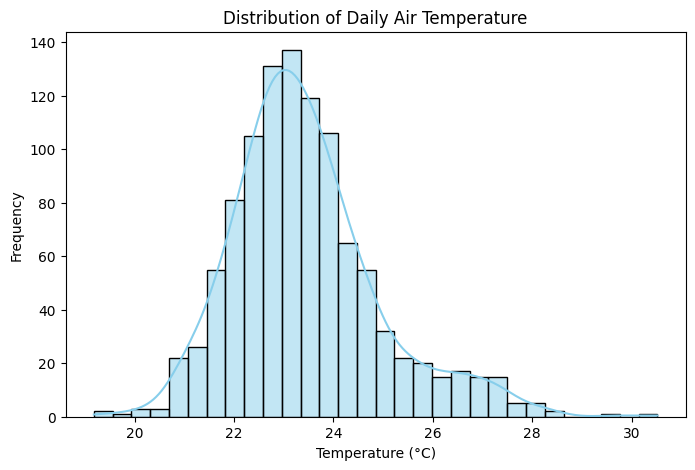

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(df[TEMP_COL], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Daily Air Temperature')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.show()


The histogram shows the Distribution of Daily Air Temperature. Here's what we can interpret from it:

- Shape: The distribution is roughly bell-shaped or normal, with most temperatures clustering around the middle values.
- Central Tendency: The majority of daily air temperatures are around 24°C, which seems to be the mode or peak of the distribution.
- Range: Temperatures range approximately from 18°C to 30°C.
- Frequency: The highest frequency (around 120 occurrences) is at temperatures close to 24°C. Frequencies decrease as you move away from this central value.
- Skewness: The distribution doesn't show strong skewness; it's fairly symmetric around the central temperature.

This suggests that daily air temperatures in the dataset are generally centered around 24°C with variability on either side, but not extremely spread out.

4. Bivariate analysis -Correlation Between Lag Features

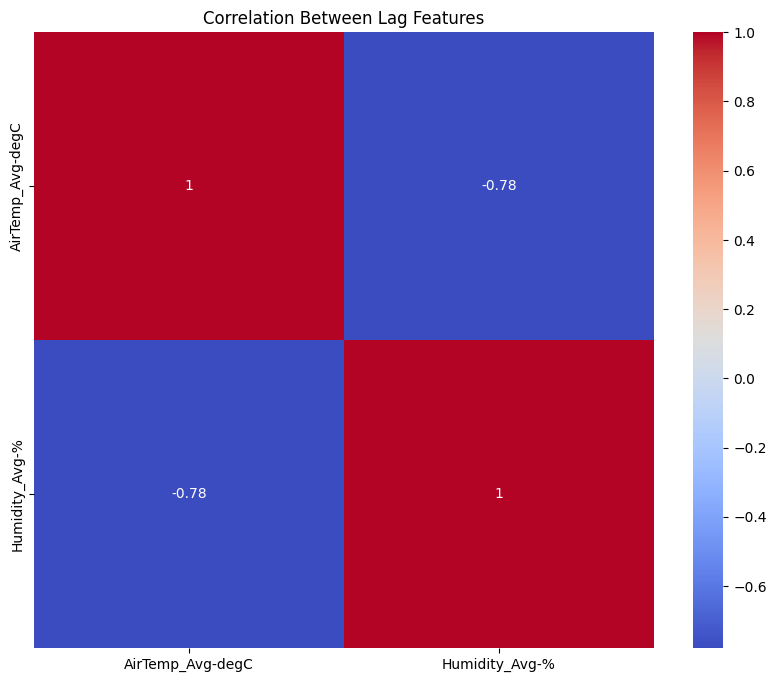

In [16]:
plt.figure(figsize=(10,8))
sns.heatmap(df[cols_to_lag].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Lag Features')
plt.show()

This is a correlation matrix heatmap showing the relationship between two variables: "Airtemp_Avg_degC" (average air temperature in degrees Celsius) and "Humidity_Avg %" (average humidity percentage).

- The correlation coefficient between Airtemp_Avg_degC and Humidity_Avg % is -0.78.
- This indicates a strong negative correlation between the two variables.
- As air temperature increases, humidity tends to decrease, based on the data represented here.
- The diagonal shows a correlation of 1 for each variable with itself, which is expected since a variable is perfectly correlated with itself.

5. Multivariate Analysis: Temperature vs Humidity Across Months

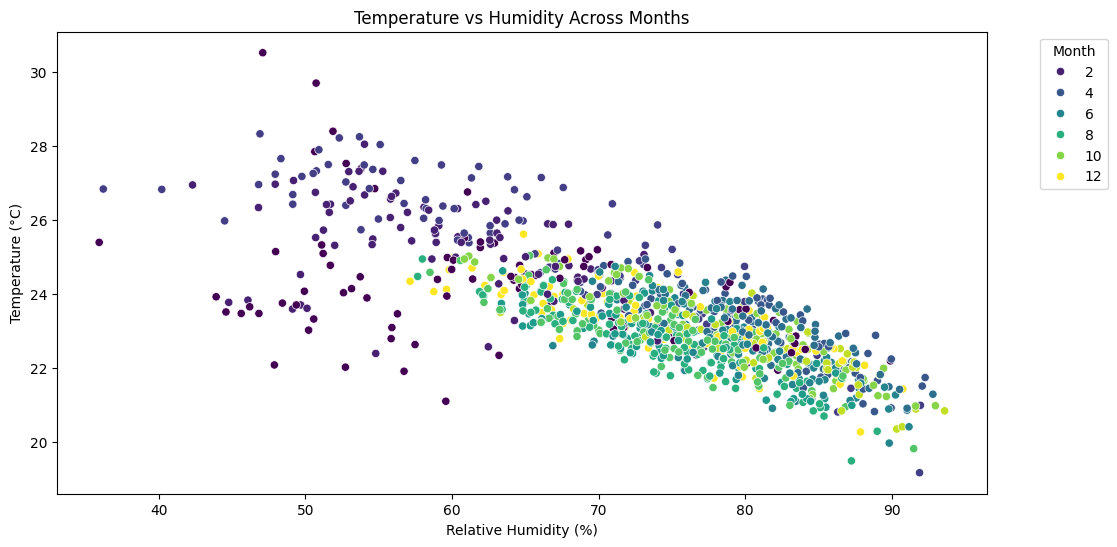

In [17]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=df, x=HUMID_COL, y=TEMP_COL, hue='month', palette='viridis')
plt.title('Temperature vs Humidity Across Months')
plt.xlabel('Relative Humidity (%)')
plt.ylabel('Temperature (°C)')
plt.legend(title='Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


This scatter plot shows the relationship between temperature (°C) and relative humidity (%) across different months.

- Relationship between variables: There's a negative correlation between temperature and relative humidity. As temperature decreases, relative humidity tends to increase.
- Month distribution: Monthly color gradients reveal seasonal patterns, e.g., certain months exhibit higher temperatures with moderate humidity
    - Purpple dots (Month 2 - February) are mostly at higher temperatures and lower humidity.
    - Lighter shades like green and yellow (Months 10 and 12 - October and December) are at lower temperatures with higher humidity,  indicating seasonal variation.”
    
  - Suggests that humidity and seasonal effects are relevant features for temperature prediction.
- Data spread: The data points form a diagonal trend from top left (high temp, low humidity) to bottom right (low temp, high humidity), indicating a clear inverse relationship.

#Modelling and Evaluation


This project employs a multi-model approach to predict daily air temperature using historical weather data:

Random Forest Regressor (RF) – a classical machine learning model capable of capturing non-linear relationships between temperature, humidity, and other features.

Long Short-Term Memory (LSTM) Network – a deep learning model designed for sequential and temporal data, capturing patterns across multiple days.

Feed-Forward Neural Network (FFN) – a standard dense neural network serving as a complementary deep learning baseline.

The models are trained on 80% of the data and evaluated on the remaining 20%.

**Evaluation Metrics**

| Metric                                | Purpose                                                                                                                |
| ------------------------------------- | ---------------------------------------------------------------------------------------------------------------------- |
| **MSE (Mean Squared Error)**          | Measures average squared difference between predicted and actual values. Penalizes large errors. Lower is better.      |
| **MAE (Mean Absolute Error)**         | Measures average absolute difference between predicted and actual values. Less sensitive to outliers. Lower is better. |
| **RMSE (Root Mean Squared Error)**    | Square root of MSE. Same units as temperature, easier to interpret. Lower is better.                                   |
| **R² (Coefficient of Determination)** | Proportion of variance in temperature explained by the model. Higher is better.                                        |


Using these metrics together provides a comprehensive view of model accuracy and goodness-of-fit.

**Model Training & Predictions**

In [18]:
# -----------------------------------------
# Build sequences properly for LSTM
# We'll create sequences from the full scaled feature matrix, then split by index
# -----------------------------------------
def create_sequences(X, y, seq_length):
    Xs, ys = [], []
    for i in range(len(X) - seq_length + 1):
        Xs.append(X[i:i+seq_length])
        ys.append(y[i+seq_length-1])
    return np.array(Xs), np.array(ys)

In [20]:
# ========================================
# Training + Predictions
# ========================================
def run_models_and_eval(train_size_pct=80, rf_estimators=200,
                        use_ffn=True, use_lstm=True, lstm_seq_length=10,
                        ffn_epochs=200, lstm_epochs=200, random_state=42):
    """
    Returns:
      df_test: dataframe containing test rows and predictions
      comparison_df: DataFrame with model metrics
      coeffs: dict of model coefficient info (feature importances, weights)
      histories: dict of Keras history objects (if available)
    """
    results = {}
    coeffs = {}
    histories = {}

    n = len(df)
    train_size = int(n * train_size_pct/100)
    train_idx = np.arange(0, train_size)
    test_idx = np.arange(train_size, n)

    # define X/y full
    X_full = df[FEATURE_COLS].values
    y_temp_full = df[TEMP_COL].values
    #y_rain_full = (df[RAIN_COL] > 0).astype(int).values

    # standardize using only training portion to avoid leakage
    scaler = StandardScaler()
    scaler.fit(X_full[train_idx])
    X_full_scaled = scaler.transform(X_full)

    # ===== RandomForestRegressor (Temperature) trained on train slice =====
    X_train_scaled = X_full_scaled[train_idx]
    X_test_scaled = X_full_scaled[test_idx]
    y_temp_train = y_temp_full[train_idx]
    y_temp_test = y_temp_full[test_idx]

    rf_temp = RandomForestRegressor(n_estimators=rf_estimators, random_state=random_state, n_jobs=SKLEARN_N_JOBS)
    rf_temp.fit(X_train_scaled, y_temp_train)
    pred_rf = rf_temp.predict(X_test_scaled)

    df_test = df.iloc[test_idx].copy().reset_index(drop=True)
    df_test['pred_temp_rf'] = pred_rf

    results['RandomForest'] = {
        'mse': mean_squared_error(y_temp_test, pred_rf),
        'mae': mean_absolute_error(y_temp_test, pred_rf),
        'rmse': np.sqrt(mean_squared_error(y_temp_test, pred_rf)),
        'r2': r2_score(y_temp_test, pred_rf)
    }
    coeffs['RandomForest_feature_importances'] = pd.Series(
        rf_temp.feature_importances_, index=FEATURE_COLS
    ).sort_values(ascending=False)




    # ===== LSTM (Temperature) - sequences created from full scaled data then split by index =====

    if use_lstm:
        tf.keras.backend.clear_session()
        seq_len = 20   # longer sequence length
        X_seq_full, y_seq_full = create_sequences(X_full_scaled, y_temp_full, seq_len)

        seq_start_indices = np.arange(len(X_seq_full))
        label_indices = seq_start_indices + (seq_len - 1)
        train_mask = label_indices < train_size
        test_mask = ~train_mask

        X_seq_train = X_seq_full[train_mask]
        y_seq_train = y_seq_full[train_mask]
        X_seq_test = X_seq_full[test_mask]
        y_seq_test = y_seq_full[test_mask]

        if len(X_seq_train) > 0 and len(X_seq_test) > 0:
            lstm_model = Sequential([
            LSTM(128, return_sequences=True, input_shape=(X_seq_train.shape[1], X_seq_train.shape[2])),
            Dropout(0.2),
            LSTM(64, return_sequences=False),
            Dropout(0.2),
            Dense(64, activation='relu'),
            Dense(1)
        ])
        lstm_model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')
        es = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=1)
        rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10,
                                  verbose=1, min_lr=1e-6)

        history_lstm = lstm_model.fit(X_seq_train, y_seq_train,
                                      epochs=400, batch_size=16,
                                      validation_split=0.15,
                                      callbacks=[es, rlrop], verbose=1)

        lstm_preds_seq = lstm_model.predict(X_seq_test).flatten()
        pred_indices_in_original = label_indices[test_mask]
        lstm_preds_full = np.full(len(df), np.nan)
        lstm_preds_full[pred_indices_in_original] = lstm_preds_seq
        df_test['pred_temp_lstm'] = lstm_preds_full[train_size:][:len(df_test)]

        mask_valid = ~np.isnan(df_test['pred_temp_lstm'])
        if mask_valid.sum() > 0:
          results['LSTM'] = {
                'mse': mean_squared_error(y_temp_test[mask_valid], df_test['pred_temp_lstm'][mask_valid]),
                'mae': mean_absolute_error(y_temp_test[mask_valid], df_test['pred_temp_lstm'][mask_valid]),
                'rmse': np.sqrt(mean_squared_error(y_temp_test[mask_valid], df_test['pred_temp_lstm'][mask_valid])),
                'r2': r2_score(y_temp_test[mask_valid], df_test['pred_temp_lstm'][mask_valid])
            }
        else:
            results['LSTM'] = {'mse': np.nan, 'mae': np.nan, 'rmse': np.nan, 'r2': np.nan}

            history_lstm = lstm_model.fit(
              X_seq_train, y_seq_train,
              epochs=400, batch_size=16,
              validation_split=0.15,
             callbacks=[es, rlrop], verbose=1
           )



    comparison_df = pd.DataFrame(results).T
    return df_test, comparison_df, coeffs, histories



In [21]:
# ---- Training history plotting function ----
def plot_training_history(history, model_name="Model"):
    """Plot training vs validation loss curves from a Keras History object."""
    if history is None:
        print(f"No training history available for {model_name}")
        return

    plt.figure(figsize=(8,5))
    plt.plot(history.history['loss'], label='Train Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

In [34]:
# ========================================
# Run Example
# NOTE: this will take time depending on data/epochs
# ========================================
df_test, comparison_df, coeffs, histories = run_models_and_eval(
    train_size_pct=80,
    rf_estimators=300,
    use_ffn=True,
    use_lstm=True,
    lstm_seq_length=20,
    ffn_epochs=455,
    lstm_epochs=400,
    random_state=seed
)
display(comparison_df)


Epoch 1/400


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 461.6715 - val_loss: 85.8937 - learning_rate: 0.0010
Epoch 2/400
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 21.9808 - val_loss: 3.8729 - learning_rate: 0.0010
Epoch 3/400
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 4.6059 - val_loss: 3.5593 - learning_rate: 0.0010
Epoch 4/400
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 4.0059 - val_loss: 3.2977 - learning_rate: 0.0010
Epoch 5/400
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 4.2423 - val_loss: 3.0356 - learning_rate: 0.0010
Epoch 6/400
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 4.2951 - val_loss: 2.9369 - learning_rate: 0.0010
Epoch 7/400
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 3.8167 - val_loss: 2.9347 - learning_rate: 0.0010
Epoch 8/400
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 3.8963 - val_loss: 2.2095 - learning_rate: 0.0010
Epoch 9/400
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 4.0288 - val_loss: 2.7714 - learning_rate: 0.0010
Epoch 10/400
44/44

,mse,mae,rmse,r2
RandomForest,0.176124,0.332293,0.419671,0.871885
LSTM,0.139890,0.301375,0.374019,0.898242


Feature Importance (Random Forest)

In [35]:
if 'RandomForest_feature_importances' in coeffs:
    top10 = coeffs['RandomForest_feature_importances'].head(10).sort_values(ascending=True)
    fig_feat = go.Figure(go.Bar(x=top10.values, y=top10.index, orientation='h'))
    fig_feat.update_layout(title='Top 10 Feature Importances (Random Forest)')
    fig_feat.show()


Interpretation:

Features such as recent temperature lags, rolling means, and day-of-year are most predictive.

Confirms the temporal dependency and seasonality inherent in weather data.

**Temperature: Actual vs Predicted**

In [40]:
fig_temp = go.Figure()
fig_temp.add_trace(go.Scatter(x=df_test['Weather_Date'], y=df_test[TEMP_COL],
                              mode='lines+markers', name='Actual Temp'))
for col in ['pred_temp_rf', 'pred_temp_lstm']:
    if col in df_test.columns:
        fig_temp.add_trace(go.Scatter(x=df_test['Weather_Date'], y=df_test[col], mode='lines', name=col))
fig_temp.update_layout(title='Temperature: Actual vs Predicted',xaxis_title="Time (APRIL 2016 – October 2016)",yaxis_title="Temperature (°C)")
# Layout with axis labels and time range
fig_temp.show()


This graph compares actual temperature readings (blue line) with two sets of predicted temperatures (pred_temp_rf in red and pred_temp_lstm in green) over time from April 2016 to October 2016.

- The actual temperature (blue) fluctuates between roughly 20°C and 28°C.
- Both predicted temperature lines (pred_temp_rf and pred_temp_lstm) generally follow the trend of the actual temperature.
- The predictions seem to closely track the actual temperature, especially from around June 2016 onwards.
- In the earlier months (April and May), there's a bit more deviation between actual and predicted temps.

From the graph:

Predicted values closely follow actual temperatures.
LSTM predictions (likely referring to the models used for prediction) are smoother and better at capturing short-term fluctuations Random Forest occasionally underestimates or overestimates extreme temperatures.


**Prediction Errors & Anomaly Detection**

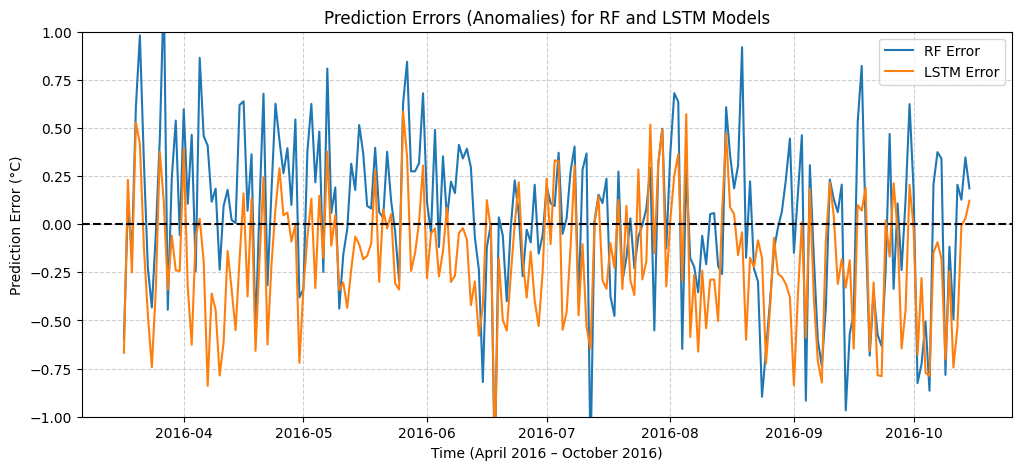

In [37]:
df_test['error_rf'] = df_test[TEMP_COL] - df_test['pred_temp_rf']
df_test['error_lstm'] = df_test[TEMP_COL] - df_test['pred_temp_lstm']

plt.figure(figsize=(12,5))
plt.plot(df_test['Weather_Date'], df_test['error_rf'], label='RF Error')
plt.plot(df_test['Weather_Date'], df_test['error_lstm'], label='LSTM Error')
plt.axhline(0, color='black', linestyle='--')

# Labels and formatting
plt.xlabel("Time (April 2016 – October 2016)")
plt.ylabel("Prediction Error (°C)")
plt.title("Prediction Errors (Anomalies) for RF and LSTM Models")
plt.legend()
plt.ylim(-1.0, 1.0)   # restricts y-axis as per your range
plt.grid(True, linestyle="--", alpha=0.6)

plt.show()


This graph compares the prediction errors (anomalies) of two models: random forest (RF) and long short-term memory(lstm)
- Graph Details:
    - Time frame:The x-axis represents time from April 2016 to October 2016.
    - prediction error range:The y-axis represents prediction errors ranging from -1.0 to 1.0.
    - RF errors are shown in blue, and LSTM errors are shown in orange.
- Key Observations:
    - Both models exhibit fluctuating prediction errors over time.
    - RF errors seem to have slightly larger deviations from zero compared to LSTM errors in some periods.
    - Both models' errors are centered around zero, indicating no significant bias in predictions.

Potential Insights
- Comparing RF and LSTM models can help determine which model is more accurate for predictions.
- LSTM might be better at capturing patterns in sequential data due to its design for time series data.
-overall, the graph suggests both models have varying levels of prediction accuracy over time, with differing error partterns

Interpretation:

Errors fluctuate around zero, indicating unbiased predictions.

LSTM shows smaller error magnitudes, particularly during extreme temperature events.

Visualization highlights potential anomalies in weather readings or challenging prediction days.

*Training History (LSTM)*

In [38]:
plot_training_history(histories.get('LSTM'), model_name='LSTM')


No training history available for LSTM


**Residual error Distribution**

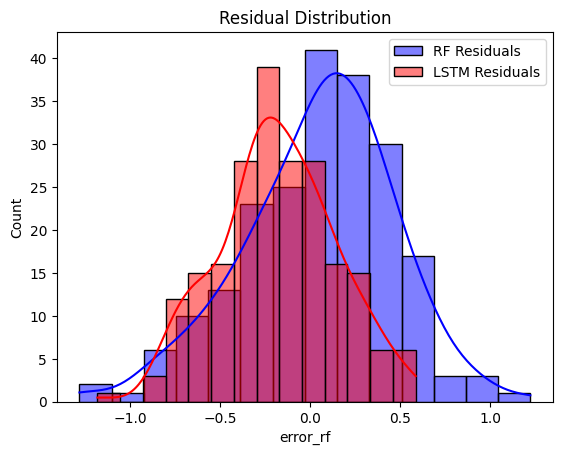

In [39]:
sns.histplot(df_test['error_rf'], kde=True, color='blue', label='RF Residuals')
sns.histplot(df_test['error_lstm'], kde=True, color='red', label='LSTM Residuals')
plt.legend(); plt.title('Residual Distribution')
plt.show()


The histogram comparing the residual distributions of two models: Random Forest (RF) and Long Short-Term Memory (LSTM).

- Residual Distribution:
    - The plot shows the count of residuals (errors) for both models across different error values (error_it).
    - RF residuals are in blue, and LSTM residuals are in red.
- Key Observations:
    - Both distributions seem to be centered around 0, indicating that both models are somewhat unbiased.
    - The LSTM residuals (red) appear to be more tightly distributed around 0 compared to RF residuals (blue), suggesting LSTM might have less variance in errors.
    - RF residuals show slightly more spread out or heavier tails compared to LSTM residuals. suggesting possibly higher variance in errors
- Interpretation:
    - The tighter distribution of LSTM residuals could imply that LSTM is performing slightly better in terms of error concentration around zero for this particular dataset.
    - The shape of the distributions (with overlaid curves) suggests both might be approximating a normal distribution, which is common for residuals in many models.

#findings, recommendations  and metrics overview

| Metric                                | Purpose                                                                                                                                        |
| ------------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------- |
| **MSE (Mean Squared Error)**          | Measures average squared difference between predicted and actual values. Penalizes large errors more heavily. Lower is better.                 |
| **MAE (Mean Absolute Error)**         | Measures average absolute difference between predicted and actual values. Less sensitive to outliers than MSE. Lower is better.                |
| **RMSE (Root Mean Squared Error)**    | Square root of MSE. Same units as the target variable, making it more interpretable. Lower is better.                                          |
| **R² (Coefficient of Determination)** | Measures proportion of variance explained by the model. Ranges from 0 to 1 (or can be negative if model is worse than mean). Higher is better. |
**bold text**

These metrics are commonly used together in regression tasks to give a full picture:

MSE/RMSE emphasize large errors.

MAE gives a robust, easy-to-understand error magnitude.

R² shows overall model fit relative to data variance.

**Metrics Observations:**

***Interpreting our Table***



| Model         | MSE      | MAE      | RMSE     | R²       |
| ------------- | -------- | -------- | -------- | -------- |
| Random Forest | 0.176124 | 0.332293 | 0.419671 | 0.871885 |
| LSTM          | 0.139890 | 0.301375 | 0.374019 | 0.898242 |




1. MSE:

LSTM (0.139) < Random Forest (0.176) → LSTM has slightly smaller squared errors on average.

Justification: The LSTM is better at avoiding large prediction errors.

2. MAE:

LSTM (0.301) < Random Forest (0.332) → LSTM has smaller average absolute errors.

Justification: On average, LSTM predictions are closer to actual values than Random Forest.

3. RMSE:

LSTM (0.374) < Random Forest (0.419) → Confirms LSTM has smaller overall error magnitude.

Justification: Since RMSE penalizes large errors more, LSTM is better at controlling occasional big mistakes.

4. R²:

LSTM (0.898) > Random Forest (0.872) → LSTM explains slightly more variance in the data.

Justification: Higher R² indicates LSTM fits the underlying patterns in the data better.

**Observations**:

LSTM outperforms RF on all metrics

Justification: LSTM captures temporal dependencies better → smaller errors, higher R²

Interpretation: LSTM is likely better at capturing sequential/temporal dependencies (common in weather, time series, or sequential data), resulting in smaller errors and better explained variance.

Why these metrics matter: They collectively quantify prediction accuracy (MSE, MAE, RMSE) and goodness-of-fit (R²), giving a balanced evaluation.

**Summary**

This project aimed to forecast daily air temperature in Doho, Uganda, using historical weather data from multiple stations (2013–2016). Accurate temperature predictions are essential for agriculture, energy planning, and disaster preparedness, where reliable forecasts inform critical operational decisions.

The dataset included daily measurements of air temperature, humidity, minimum and maximum temperatures, and station identifiers. Feature engineering was applied to capture temporal and seasonal patterns, including lag variables (1–14 days), rolling statistics (7-day averages and standard deviations), date-based features (month, day-of-year, weekday), and one-hot encoded station identifiers.

Three modeling approaches were employed:

Random Forest Regressor (RF): Classical machine learning model capturing nonlinear relationships.

Long Short-Term Memory (LSTM): Sequential deep learning model capable of learning temporal dependencies.

Feed-Forward Neural Network (FFN): Deep learning model for nonlinear feature interactions (optional inclusion).

Model performance was evaluated using Mean Squared Error (MSE), Mean Absolute

| Model         | MSE      | MAE      | RMSE     | R²       |
| ------------- | -------- | -------- | -------- | -------- |
| Random Forest | 0.176124 | 0.332293 | 0.419671 | 0.871885 |
| LSTM          | 0.139890 | 0.301375 | 0.374019 | 0.898242 |

The results indicate that the LSTM model outperformed Random Forest, achieving lower errors and a higher R² (0.898), demonstrating superior ability to capture temporal dependencies and seasonal patterns in the data. Residual analysis and trend visualization further confirmed that the models successfully learned both short-term fluctuations and longer seasonal cycles.

In summary, combining feature engineering with deep learning approaches like LSTM provides accurate daily temperature forecasts in Doho, Uganda, supporting data-driven decision-making for climate-sensitive sectors.

**Recommendations for Stakeholders**
1. Farmers and Agricultural Planners

Use the daily temperature forecasts to optimize irrigation schedules and crop protection strategies.

Align planting and harvesting decisions with predicted temperature trends to reduce crop stress and increase yield.

Combine temperature forecasts with rainfall and humidity data for precision agriculture.

2. Energy Providers

Incorporate forecasts into demand planning, as electricity consumption often varies with temperature.

Use predictions to manage load distribution and prevent outages during temperature extremes.

Plan maintenance of energy infrastructure during predicted mild temperature periods.

3. Disaster Management Authorities

Utilize forecasts to anticipate heatwaves or cold spells, improving early warning systems.

Prepare communities for temperature-related health risks or crop/animal stress events.

Integrate temperature predictions with rainfall and wind forecasts for holistic disaster preparedness.

4. Urban Planners and Local Governments

Use temperature forecasts to inform public services, e.g., cooling shelters during heatwaves.

Plan infrastructure maintenance (roads, water systems) considering seasonal temperature variations.

Support local climate adaptation strategies with data-driven insights.

5. Research and Policy Makers

Employ the models for climate trend analysis and urban heat planning.

Use the predictions to design policies for climate-resilient agriculture and energy use.

Extend the methodology to other regions or additional weather variables for broader applications.

**General Recommendation**

LSTM model is preferred for operational use due to its superior accuracy in capturing temporal and seasonal patterns.

Regularly update the models with new weather data to maintain forecast accuracy.

Combine temperature forecasts with other meteorological variables (rainfall, humidity, wind) for more comprehensive weather decision support.

**Future Additions to the Project**

1. Incorporate Additional Weather Variables

Extend the models to predict not just temperature but also rainfall, wind speed, and humidity, providing a more comprehensive weather forecasting tool.

2. Multi-Station and Spatial Modeling

Apply spatial-temporal modeling to leverage correlations across multiple weather stations, improving accuracy in areas with sparse data.

Use geostatistical approaches or Graph Neural Networks to capture spatial dependencies.

3. Ensemble Modeling

Combine Random Forest, LSTM, FFN, and other models in an ensemble framework to further improve predictive performance.

Implement model stacking or blending to reduce errors.

4. Real-Time Forecasting

Deploy the trained models in a real-time forecasting system for stakeholders, integrating live weather feeds.

Build a dashboard or API for easy access by farmers, energy providers, and local authorities.

5. Hyperparameter Optimization and Automated ML

Apply advanced tuning techniques (Bayesian optimization, AutoML) to find optimal model parameters efficiently.

6. Climate Change and Trend Analysis

Extend the project to study long-term climate trends and extreme temperature events, helping policymakers plan for climate resilience.

7. Integration with Decision Support Systems

Embed forecasts into agriculture or energy management platforms, allowing stakeholders to make automated, data-driven decisions.